In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3


In [2]:
image_path = keras.utils.get_file("image_2.jpg", "https://cdn.britannica.com/78/43678-050-F4DC8D93/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg")
layer_settings = {
    "mixed4":1.0,
    "mixed5":1.5,
    "mixed6":2.0,
    "mixed7":2.5
}

lr = 0.01
num_octave = 5
octave_scale = 1.2
iteration = 20
max_loss = 15

689361/689361 [==============================] - 0s 0us/step


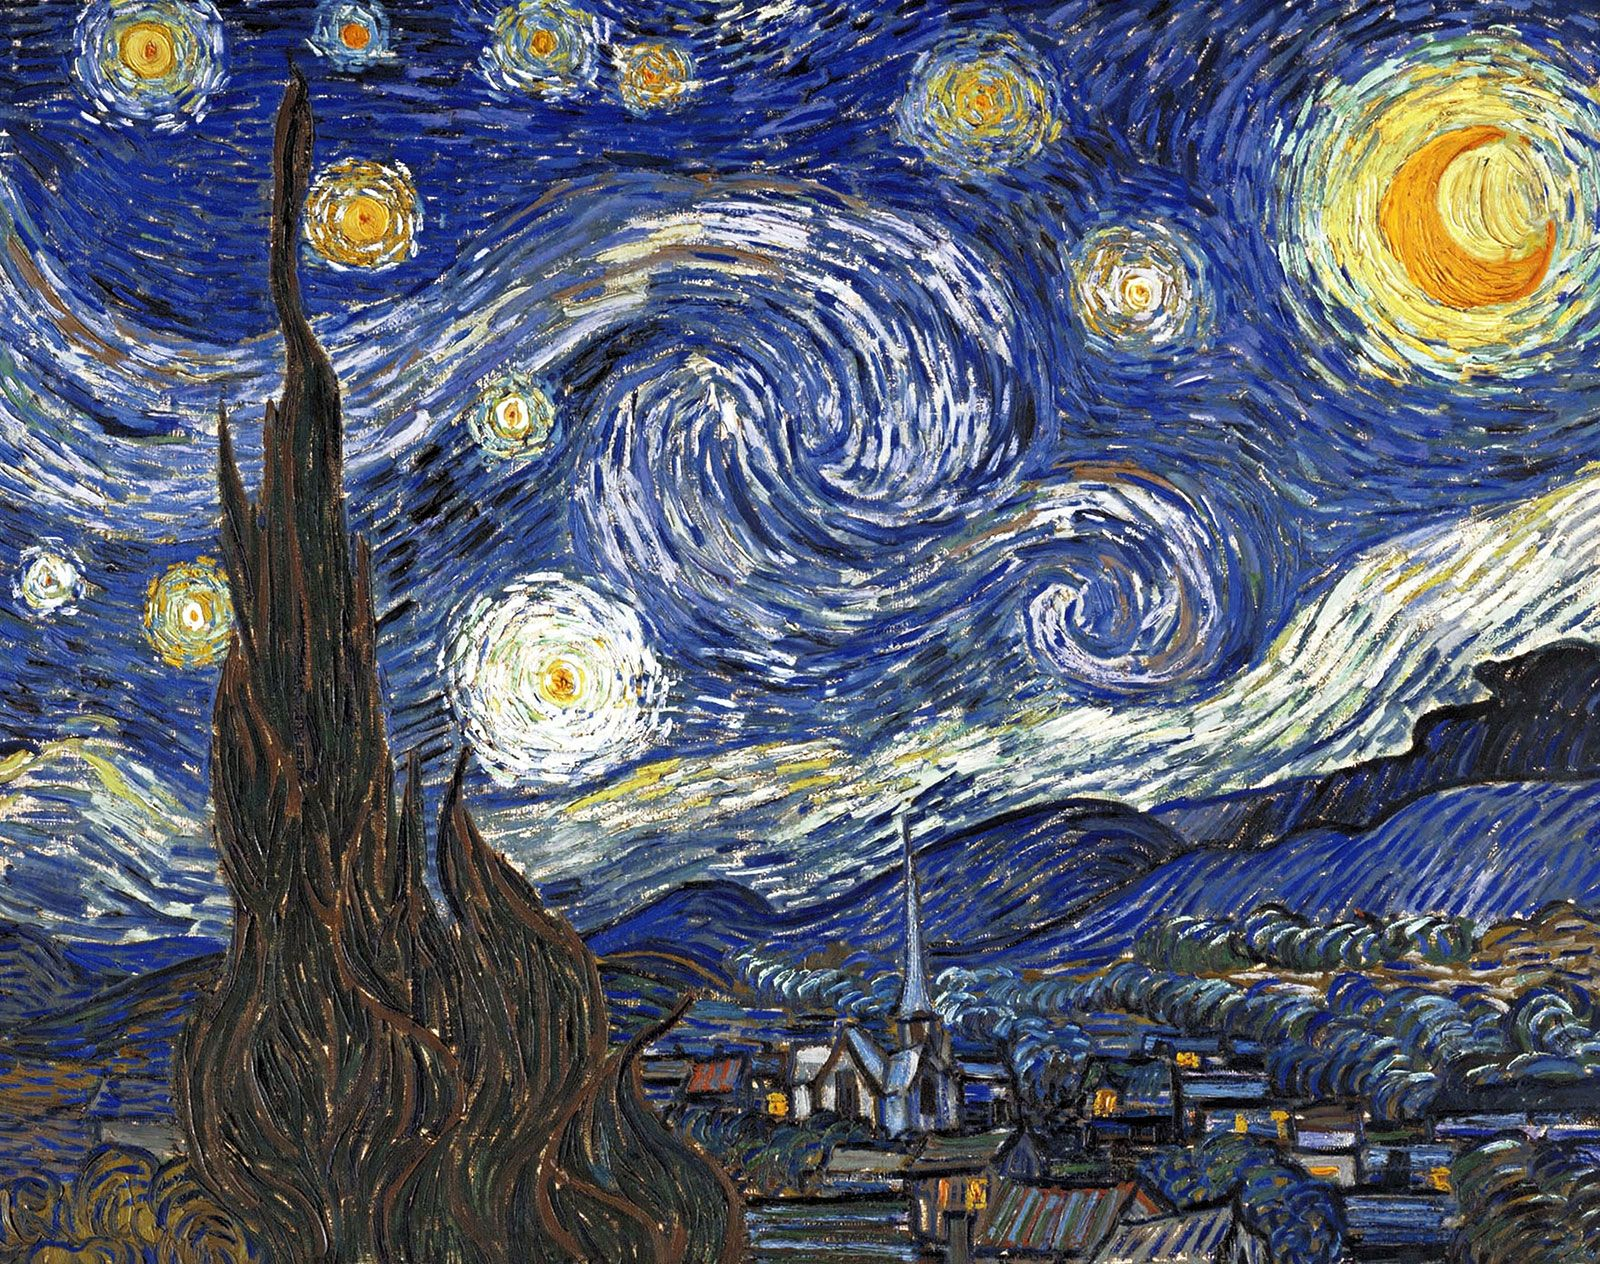

In [3]:
from IPython.display import Image, display
display(Image(image_path))

In [4]:
def preprocess_image(image_path):
  img = keras.preprocessing.image.load_img(image_path)
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img


def deprocess_image(x):
  x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2
  x += 0.5
  x *= 255.0
  x = np.clip(x, 0, 255).astype("uint8")
  return x

In [5]:
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

outputs = dict(
    [
     (layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs)

In [6]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
    loss += coeff*tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling

  return loss

In [7]:
def gradient_ascent_step(img, lr):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img)

  grads = tape.gradient(loss, img)
  grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)) + 1e-6, 1e-6)
  img += lr * grads

  return loss, img


def gradient_ascent(img, iter, lr, max_loss=None):
  for i in range(iter):
    loss, img = gradient_ascent_step(img, lr)

    if max_loss is not None and loss > max_loss:
      break

    print(f"Loss value at step {i}: {loss}")

  return img

In [8]:
orig_img = preprocess_image(image_path)
orig_shape = orig_img.shape[1:3]

shapes = [orig_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim/(octave_scale**i)) for dim in orig_shape])
  shapes.append(shape)

shapes = shapes[::-1]
shrunk_orig_img = tf.image.resize(orig_img, shapes[0])

img = tf.identity(orig_img)
for i, shape in enumerate(shapes):
  print(f"Octave {i}, shape: {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_ascent(img, iter=iteration, lr=lr, max_loss=max_loss)

  upscaled_shrunk_orig_img = tf.image.resize(shrunk_orig_img, shape)
  downscaled_orig_img = tf.image.resize(orig_img, shape)
  lost_details = downscaled_orig_img - upscaled_shrunk_orig_img

  img += lost_details
  shrunk_orig_img = tf.image.resize(orig_img, shape)

Octave 0, shape: (609, 771)
Loss value at step 0: 0.6582208275794983
Loss value at step 1: 0.9080837368965149
Loss value at step 2: 1.1436954736709595
Loss value at step 3: 1.3540124893188477
Loss value at step 4: 1.5400749444961548
Loss value at step 5: 1.7105971574783325
Loss value at step 6: 1.886594295501709
Loss value at step 7: 2.045381546020508
Loss value at step 8: 2.2114145755767822
Loss value at step 9: 2.3685591220855713
Loss value at step 10: 2.5316073894500732
Loss value at step 11: 2.6827392578125
Loss value at step 12: 2.837935447692871
Loss value at step 13: 2.961456775665283
Loss value at step 14: 3.108588218688965
Loss value at step 15: 3.239504814147949
Loss value at step 16: 3.3893027305603027
Loss value at step 17: 3.522749423980713
Loss value at step 18: 3.665273904800415
Loss value at step 19: 3.77730393409729
Octave 1, shape: (731, 925)
Loss value at step 0: 1.0833275318145752
Loss value at step 1: 1.6063191890716553
Loss value at step 2: 1.9952785968780518
Loss

In [9]:
keras.preprocessing.image.save_img("image.png", deprocess_image(img.numpy()))